# Assignment #4: Extracting syntactic groups using recurrent networks
Author: Pierre Nugues

In this assignment, you will create a system to extract syntactic groups from a text. You will apply it to the CoNLL 2000 dataset. You will train your models with PyTorch.

Be aware that in PyTorch, the data matrices, by default, have an unconventional ordering with recurrent networks. To have a batch ordering similar to what we saw during the course, you must use the `batch_first=True` argument. See here https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html and https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Before you start the assignment, please run the prerequisites from the prerequistites notebook.

## Objectives

The objectives of this assignment are to:
* Write a program to detect partial syntactic structures called groups or chunks
* Understand the principles of supervised machine learning techniques applied to language processing
* Write a short report of 2 to 3 pages on the assignment

## Preliminaries

### Imports

This instruction may solve installation conflicts

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import bs4
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import numpy as np
from numpy import dot
from numpy.linalg import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

import conlleval

### Seeds
Making things reproduceable

In [3]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

### Constants

In [4]:
EMBEDDING_DIM = 300 #50
LSTM_HIDDEN_DIM = 32

### The datasets

You may need to adjust the paths to load the datasets from your machine.

In [5]:
train_file = 'corpus/train.txt'
test_file = 'corpus/test.txt'

## Reading the files

You will now convert the dataset in a Python data structure. Read the functions below to load the datasets. They store the corpus in a list of sentences. Each sentence is a list of rows, where each row is a dictionary.

In [6]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [7]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2000 files have three columns: The wordform, `form`, its part of speech, `pos`, and the tag denoting the syntactic group also called the chunk tag, `chunk`.

In [8]:
column_names = ['form', 'pos', 'chunk']

We load the corpus as a list of dictionaries

In [9]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)
train_dict[10:11]

[[{'form': 'He', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'reckons', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'current', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'account', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'deficit', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'will', 'pos': 'MD', 'chunk': 'B-VP'},
  {'form': 'narrow', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-PP'},
  {'form': 'only', 'pos': 'RB', 'chunk': 'B-NP'},
  {'form': '#', 'pos': '#', 'chunk': 'I-NP'},
  {'form': '1.8', 'pos': 'CD', 'chunk': 'I-NP'},
  {'form': 'billion', 'pos': 'CD', 'chunk': 'I-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': '.', 'pos': '.', 'chunk': 'O'}]]

## Embeddings

### Reading the embeddings

In [10]:
# embedding_file = 'corpus/glove.6B.100d.txt'
# embedding_file = 'corpus/glove.6B.300d.txt'
embedding_file = 'corpus/glove.42B.300d.txt'
# embedding_file = 'corpus/glove.840B.300d.txt'

Apply the function below that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embedding vectors.

In [11]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [12]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

In [13]:
'# words in embedding dictionary: {}'.format(len(embedded_words))

'# words in embedding dictionary: 1917494'

### Understanding the embeddings

In [14]:
embedded_words[100000:100010]

['1/2/2008',
 '1/2/2009',
 '1/2/2010',
 '1/2/2011',
 '1/2/2012',
 '1/2/2013',
 '1/2/3',
 '1/2/4',
 '1/2/5',
 '1/20']

In [15]:
embeddings_dict['chords'][:20]

array([ 0.73117 , -0.44407 ,  0.22863 ,  0.32582 , -0.069017,  0.29342 ,
       -1.6415  , -0.23372 ,  0.11325 , -0.80541 ,  0.58405 ,  0.16712 ,
       -0.89039 ,  0.37771 , -0.24962 ,  0.40288 , -0.10095 ,  0.064693,
       -0.18085 ,  0.51575 ], dtype=float32)

Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 10 closest words to the words _table_, _france_, and _sweden_.

In [16]:
# Write your code here
def cosine_similarity(d1, d2):
    return np.dot(d1, d2) / (np.sqrt(np.dot(d1, d1)) * np.sqrt(np.dot(d2, d2)))
def closest2(target_word, embeddings, count=10):
    distances = []
    for word in embeddings:
        distances.append((word, cosine_similarity(embeddings[target_word], embeddings[word])))
    distances.sort(key=lambda x: x[1], reverse=True)
    return list(map(lambda x: x[0], distances[0:count]))

In [17]:
closest2('france', embeddings_dict)

['france',
 'europe',
 'paris',
 'belgium',
 'french',
 'spain',
 'germany',
 'italy',
 'switzerland',
 'luxembourg']

In [18]:
closest2('sweden', embeddings_dict)

['sweden',
 'denmark',
 'norway',
 'finland',
 'netherlands',
 'germany',
 'estonia',
 'stockholm',
 'switzerland',
 'belgium']

## Extracting the ${X}$ and ${Y}$ Lists of Symbols from the Datasets

For each sentence, you will build an input sequence, $\mathbf{x}$, corresponding to the words and an output one, $\mathbf{y}$, corresponding to the chunk tags.

Write a `build_sequences(corpus_dict, key_x='form', key_y='chunk', tolower=True)` function that, for each sentence, returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and chunk tags. Set the words in lower case if `tolower` is true.

For the 11th sentence of the training set, you should have:<br/>
`x = ['he',  'reckons',  'the',  'current',  'account',  'deficit',  'will',  'narrow',  'to',  'only',  '#',  '1.8',  'billion',  'in',  'september',  '.']`

`y = ['B-NP', 'B-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-VP', 'I-VP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'O']`

In [19]:
# Write your code
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        if tolower:
            X.append([word[key_x].lower() for word in sentence])
        else:
            X.append([word[key_x] for word in sentence])
        Y.append([word[key_y] for word in sentence])
    return X, Y

In [20]:
X_train_symbs, Y_train_symbs = build_sequences(train_dict, key_x='form', key_y='chunk')

In [21]:
print(X_train_symbs[10])

['he', 'reckons', 'the', 'current', 'account', 'deficit', 'will', 'narrow', 'to', 'only', '#', '1.8', 'billion', 'in', 'september', '.']


In [22]:
print(Y_train_symbs[10])

['B-NP', 'B-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-VP', 'I-VP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set as well as in GloVe. You should find 401,464 different words. You will proceed in two steps.

First extract the list of unique words `words` from the CoNLL training set and the list of chunk tags, `chunks`. You will sort them

In [23]:
# Write your code: List of words and tags in CoNLL
words = []
chunks = []
for sentence in train_dict:
    for word in sentence:
        words.append(word['form'].lower())
        chunks.append(word['chunk'])
words = sorted(list(set(words)))
chunks = sorted(list(set(chunks)))

In [24]:
print('# words seen in training corpus:', len(words))
print('# Chunks tags seen:', len(chunks))

# words seen in training corpus: 17258
# Chunks tags seen: 22


In [25]:
words[4000:4010]

['casinos',
 'caspita',
 'caspita-brand',
 'cassettes',
 'cast',
 'castigated',
 'castigating',
 'castillo',
 'casting',
 'castro-medellin']

In [26]:
chunks[:10]

['B-ADJP',
 'B-ADVP',
 'B-CONJP',
 'B-INTJ',
 'B-LST',
 'B-NP',
 'B-PP',
 'B-PRT',
 'B-SBAR',
 'B-UCP']

Then, merge the list of unique CoNLL words with the words in the embeddings file. You will sort this list

In [27]:
# Write your code: Add vocabulary of embedded words
vocabulary_words = sorted(list(set(words + embedded_words)))

In [28]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 1918351


In [29]:
vocabulary_words[200000:200010]

['1913-17',
 '1913-1914',
 '1913-1914.',
 '1913-1915',
 '1913-1916',
 '1913-1917',
 '1913-1918',
 '1913-1919',
 '1913-1920',
 '1913-1921']

## Index

Create the indices `word2idx`, `chunk2idx` and inverted indices `idx2word`, `idx2chunk` for the words and the chunk tags: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words. This means that your first word will start at index 2. For the chunks, you will start at index 1.

In [30]:
# Write your code:
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2chunk = dict(enumerate(chunks, start=1))
word2idx = {v:k for k,v in idx2word.items()}
chunk2idx = {v:k for k,v in idx2chunk.items()}

The word indices

In [31]:
print(list(word2idx.items())[:25])

[('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!!!!!!', 7), ('!!!!!!!', 8), ('!!!!!!!!', 9), ('!!!!!!!!!', 10), ('!!!!!!!!!!', 11), ('!!!!!!!!!!!', 12), ('!!!!!!!!!!!!', 13), ('!!!!!!!!!!!!!', 14), ('!!!!!!!!!!!!!!', 15), ('!!!!!!!!!!!!!!!', 16), ('!!!!!!!!!!!!!!!!', 17), ('!!!!!!!!!!!!!!!!!', 18), ('!!!!!!!!!!!!!!!!!!', 19), ('!!!!!!!!!!!!!!!!!!!', 20), ('!!!!!!!!!!!!!!!!!!!!', 21), ('!!!!!!!!!!!!!!!!!!!!!', 22), ('!!!!!!!!!!!!!!!!!!!!!!', 23), ('!!!!!!!!!!!!!!!!!!!!!!!', 24), ('!!!!!!!!!!!!!!!!!!!!!!!!', 25), ('!!!!!!!!!!!!!!!!!!!!!!!!!', 26)]


The chunk indices

In [32]:
print(chunk2idx)

{'B-ADJP': 1, 'B-ADVP': 2, 'B-CONJP': 3, 'B-INTJ': 4, 'B-LST': 5, 'B-NP': 6, 'B-PP': 7, 'B-PRT': 8, 'B-SBAR': 9, 'B-UCP': 10, 'B-VP': 11, 'I-ADJP': 12, 'I-ADVP': 13, 'I-CONJP': 14, 'I-INTJ': 15, 'I-NP': 16, 'I-PP': 17, 'I-PRT': 18, 'I-SBAR': 19, 'I-UCP': 20, 'I-VP': 21, 'O': 22}


## Embedding Matrix

Create a numpy matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `np.random.uniform()`

In [33]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.random.random((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = np.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

The shape of your matrix is: (401466, 100).

In [34]:
embedding_matrix.shape

(1918353, 300)

Fill the matrix with the GloVe embeddings when available. This means: Replace the random vector with an embedding when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [35]:
# Write your code
out_of_embeddings = []
for word in vocabulary_words:
    if word in embeddings_dict:
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        out_of_embeddings.append(word)

In [36]:
len(out_of_embeddings)

857

In [37]:
out_of_embeddings[-10:]

["women's-rights",
 'woodmac',
 'worker-compensation',
 'working-girl',
 'world-commerce',
 "y'all",
 'year-before',
 'yield-management',
 'zaishuo',
 'zarett']

Embeddings of the padding symbol, idx 0, random numbers

In [38]:
embedding_matrix[0][:10]

array([-0.03084805,  0.01221088, -0.00622723,  0.02853586,  0.02799758,
       -0.02274074, -0.02235357,  0.03018722,  0.04581394,  0.03759326])

Embeddings of the word _table_, the GloVe values

In [39]:
embedding_matrix[word2idx['table']][:10]

array([-0.48524001,  0.039558  , -0.046947  , -0.056083  ,  0.84688002,
       -0.095761  , -2.54049993,  0.39072999, -0.097248  ,  0.21303999])

Embeddings of _zarett_, a word in CoNLL 2000, but not in GloVe, random numbers

In [40]:
embedding_matrix[word2idx['zarett']][:10]

array([ 0.00540048,  0.03457306, -0.01296801,  0.02510228,  0.00136785,
       -0.03044032,  0.02263095,  0.02768296, -0.01973514, -0.02316351])

## Creating the ${X}$ and ${Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the 
${X}_\text{train\_symbs}$ and ${Y}_\text{train\_symbs}$ 
lists of symbols in lists of numbers using the indices you created. Call them `X_train_idx` and `Y_train_idx`.

In [41]:
# Write your code
# We create the parallel sequences of indexes
X_train_idx = []
Y_train_idx = []
for x, y in zip(X_train_symbs, Y_train_symbs):
    X_train_idx.append([word2idx[word] for word in x])
    Y_train_idx.append([chunk2idx[chunk] for chunk in y])

Word indices of the three first sentences

In [42]:
print(X_train_idx[:3])

[[704294, 1048244, 1731494, 1455426, 1071851, 1863829, 860507, 1751214, 1710857, 499157, 1609325, 785044, 1040147, 1762233, 883861, 900752, 1599158, 9515, 806382, 900752, 1521897, 1754377, 9515, 868101, 1751214, 1617369, 443770, 1687079, 1047894, 913392, 1099957, 494188, 530486, 7570, 1312851, 759020, 18920], [660791, 1357047, 1731494, 858787, 1325916, 1157370, 7570, 1529811, 698555, 1751214, 443770, 888765, 1274105, 1445191, 987527, 997085, 1751214, 1465292, 443770, 909720, 1048244, 1673095, 1382220, 1731494, 1403053, 1853609, 18920], [621821, 493351, 1514116, 1794062, 1695484, 900752, 1673095, 987527, 563339, 845992, 623644, 1731494, 660791, 7570, 868194, 1751214, 498575, 503890, 1319837, 1445191, 1237106, 1048244, 1007689, 1217626, 1020477, 1655621, 1154387, 1742442, 18920]]


In [43]:
print(Y_train_idx[:3])

[[6, 7, 6, 16, 11, 21, 21, 21, 21, 6, 16, 16, 9, 6, 16, 7, 6, 22, 1, 7, 6, 6, 22, 11, 21, 21, 6, 16, 16, 7, 6, 16, 16, 6, 16, 16, 22], [22, 7, 6, 16, 6, 16, 6, 16, 16, 7, 6, 16, 16, 16, 11, 21, 21, 21, 6, 16, 7, 6, 7, 6, 16, 16, 22], [22, 6, 11, 6, 16, 7, 6, 11, 21, 21, 7, 6, 16, 6, 16, 11, 21, 6, 16, 16, 16, 7, 6, 16, 16, 16, 6, 16, 22]]


Chunk tag indices of the three first sentences

In [44]:
print(Y_train_idx[:3])

[[6, 7, 6, 16, 11, 21, 21, 21, 21, 6, 16, 16, 9, 6, 16, 7, 6, 22, 1, 7, 6, 6, 22, 11, 21, 21, 6, 16, 16, 7, 6, 16, 16, 6, 16, 16, 22], [22, 7, 6, 16, 6, 16, 6, 16, 16, 7, 6, 16, 16, 16, 11, 21, 21, 21, 6, 16, 7, 6, 7, 6, 16, 16, 22], [22, 6, 11, 6, 16, 7, 6, 11, 21, 21, 7, 6, 16, 6, 16, 11, 21, 6, 16, 16, 16, 7, 6, 16, 16, 16, 6, 16, 22]]


Now, pad the sentences using the `pad_sequences` function. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [ 97171, 269136, 358640, 143112, 262191, 219534,    154, 307829, 106548,
        362305,  43426, 149626, 249511, 288933, 174855, 177388, 362305, 293204,
         43426, 154301, 189360, 344283, 274536, 358640, 279589, 386150,    873,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0]
y = [22,  7,  6, 16,  6, 16,  6, 16, 16,  7,  6, 16, 16, 16, 11, 21, 21, 21,
         6, 16,  7,  6,  7,  6, 16, 16, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]
```

You will call the results `X_train_padded` and `Y_train_padded`.

In [45]:
X_train_idx = list(map(torch.LongTensor, X_train_idx))
Y_train_idx = list(map(torch.LongTensor, Y_train_idx))

In [46]:
# Write your code here
X_train_padded = pad_sequence(X_train_idx, batch_first=True)
Y_train_padded = pad_sequence(Y_train_idx, batch_first=True)

In [47]:
X_train_padded[1]

tensor([ 660791, 1357047, 1731494,  858787, 1325916, 1157370,    7570, 1529811,
         698555, 1751214,  443770,  888765, 1274105, 1445191,  987527,  997085,
        1751214, 1465292,  443770,  909720, 1048244, 1673095, 1382220, 1731494,
        1403053, 1853609,   18920,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0])

In [48]:
Y_train_padded[1]

tensor([22,  7,  6, 16,  6, 16,  6, 16, 16,  7,  6, 16, 16, 16, 11, 21, 21, 21,
         6, 16,  7,  6,  7,  6, 16, 16, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])

In [49]:
embedding_matrix = torch.FloatTensor(embedding_matrix)

## Network Architecture

Create your network consisting of one embedding layer, a simple recurrent neural network, either RNN or LSTM, and a linear layer. You will initialize the embedding layer with `embedding_matrix` using `from_pretrained()`. You may try other configurations after. As number of RNN/LSTM units use 128.

In [50]:
# Write your code
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Model(nn.Module):

    def __init__(self, embedding_matrix, embedding_dim, lstm_units, nbr_classes, bidi_lstm=False):
        super().__init__()
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, 
                                                       freeze=True, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim, lstm_units, num_layers=2, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            # twice the units if bidirectional 
            self.fc = nn.Linear(2*lstm_units, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = F.relu(lstm_out)
        logits = self.fc(lstm_out)
        return logits

Create your model

In [51]:
LSTM_HIDDEN_DIM = 24
model1 = Model(embedding_matrix, EMBEDDING_DIM, LSTM_HIDDEN_DIM, len(chunks) + 1, bidi_lstm=True)

In [52]:
model1

Model(
  (embeddings): Embedding(1918353, 300, padding_idx=0)
  (lstm): LSTM(300, 24, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=48, out_features=23, bias=True)
)

Write the loss `loss_fn` and optimizer `optimizer`.

In [53]:
# Write your code
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

## Data Loaders

In [54]:
X_train = torch.LongTensor(X_train_padded)
Y_train = torch.LongTensor(Y_train_padded)

In [55]:
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## A Few Experiments
Flattening the tensors

In [56]:
Y_train.size()

torch.Size([8936, 78])

In [57]:
Y_train.view(-1)

tensor([6, 7, 6,  ..., 0, 0, 0])

In [58]:
Y_train.view(-1).size()

torch.Size([697008])

In [59]:
# Y_train_pred = model1(X_train)

In [60]:
# Y_train_pred.size()

In [61]:
# Y_train_pred.view(-1, Y_train_pred.size()[-1]).size()

## Training the Model

We create a dictionary to store the accuracy and the loss. Th exact values are difficult to compute because of the padding symbols. We include the padding symbols in the computation. 

In [62]:
history = {}
history['accuracy'] = []
history['loss'] = []
torch.cuda.empty_cache()

We fit the model

In [63]:
from timeit import default_timer as timer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
epochs = 25
for epoch in range(epochs+1):
    start_time = timer()
    train_loss = 0
    train_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    for X_batch, Y_batch in tqdm(dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)        
        batch_cnt += 1
        Y_batch_pred = model1(X_batch)
        loss = loss_fn(Y_batch_pred.view(-1, Y_batch_pred.shape[-1]), Y_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    with torch.no_grad():
        for i in range(0, len(X_train), 256):
            x = X_train[i:i+256,:].to(device)
            y = Y_train[i:i+256].to(device)
            train_accuracy += torch.sum(torch.mul(torch.argmax(model1(x), dim=-1) == y, y > 0))
    # train_accuracy += torch.sum(torch.argmax(model1(X_train), dim=-1) == Y_train)
    history['accuracy'] += [train_accuracy.item()/torch.sum(Y_train > 0)]
    history['loss'] += [train_loss/batch_cnt]
    end_time = timer()
    print((f"Epoch: {epoch}, Train loss: {history['loss'][-1]:.3f}, Train acc.: {history['accuracy'][-1].item():.3f},  Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 280/280 [00:01<00:00, 182.05it/s]


Epoch: 0, Train loss: 1.666, Train acc.: 0.794,  Epoch time = 1.621s


100%|██████████| 280/280 [00:01<00:00, 252.10it/s]


Epoch: 1, Train loss: 0.610, Train acc.: 0.890,  Epoch time = 1.173s


100%|██████████| 280/280 [00:01<00:00, 253.20it/s]


Epoch: 2, Train loss: 0.387, Train acc.: 0.914,  Epoch time = 1.173s


100%|██████████| 280/280 [00:01<00:00, 260.54it/s]


Epoch: 3, Train loss: 0.298, Train acc.: 0.931,  Epoch time = 1.141s


100%|██████████| 280/280 [00:01<00:00, 253.27it/s]


Epoch: 4, Train loss: 0.246, Train acc.: 0.940,  Epoch time = 1.164s


100%|██████████| 280/280 [00:01<00:00, 256.31it/s]


Epoch: 5, Train loss: 0.216, Train acc.: 0.947,  Epoch time = 1.154s


100%|██████████| 280/280 [00:01<00:00, 264.91it/s]


Epoch: 6, Train loss: 0.193, Train acc.: 0.952,  Epoch time = 1.130s


100%|██████████| 280/280 [00:01<00:00, 237.78it/s]


Epoch: 7, Train loss: 0.176, Train acc.: 0.957,  Epoch time = 1.242s


100%|██████████| 280/280 [00:01<00:00, 243.04it/s]


Epoch: 8, Train loss: 0.162, Train acc.: 0.960,  Epoch time = 1.212s


100%|██████████| 280/280 [00:01<00:00, 264.04it/s]


Epoch: 9, Train loss: 0.150, Train acc.: 0.962,  Epoch time = 1.122s


100%|██████████| 280/280 [00:01<00:00, 246.73it/s]


Epoch: 10, Train loss: 0.139, Train acc.: 0.965,  Epoch time = 1.198s


100%|██████████| 280/280 [00:01<00:00, 256.11it/s]


Epoch: 11, Train loss: 0.130, Train acc.: 0.968,  Epoch time = 1.154s


100%|██████████| 280/280 [00:01<00:00, 250.73it/s]


Epoch: 12, Train loss: 0.121, Train acc.: 0.970,  Epoch time = 1.178s


100%|██████████| 280/280 [00:01<00:00, 246.63it/s]


Epoch: 13, Train loss: 0.114, Train acc.: 0.974,  Epoch time = 1.198s


100%|██████████| 280/280 [00:01<00:00, 251.09it/s]


Epoch: 14, Train loss: 0.107, Train acc.: 0.975,  Epoch time = 1.177s


100%|██████████| 280/280 [00:01<00:00, 243.26it/s]


Epoch: 15, Train loss: 0.100, Train acc.: 0.977,  Epoch time = 1.211s


100%|██████████| 280/280 [00:01<00:00, 240.96it/s]


Epoch: 16, Train loss: 0.094, Train acc.: 0.978,  Epoch time = 1.224s


100%|██████████| 280/280 [00:01<00:00, 242.92it/s]


Epoch: 17, Train loss: 0.089, Train acc.: 0.978,  Epoch time = 1.215s


100%|██████████| 280/280 [00:01<00:00, 245.48it/s]


Epoch: 18, Train loss: 0.084, Train acc.: 0.980,  Epoch time = 1.201s


100%|██████████| 280/280 [00:01<00:00, 243.77it/s]


Epoch: 19, Train loss: 0.079, Train acc.: 0.982,  Epoch time = 1.207s


100%|██████████| 280/280 [00:01<00:00, 244.87it/s]


Epoch: 20, Train loss: 0.075, Train acc.: 0.983,  Epoch time = 1.203s


100%|██████████| 280/280 [00:01<00:00, 245.05it/s]


Epoch: 21, Train loss: 0.071, Train acc.: 0.984,  Epoch time = 1.201s


100%|██████████| 280/280 [00:01<00:00, 248.88it/s]


Epoch: 22, Train loss: 0.068, Train acc.: 0.984,  Epoch time = 1.188s


100%|██████████| 280/280 [00:01<00:00, 246.61it/s]


Epoch: 23, Train loss: 0.065, Train acc.: 0.986,  Epoch time = 1.197s


100%|██████████| 280/280 [00:01<00:00, 252.03it/s]


Epoch: 24, Train loss: 0.061, Train acc.: 0.986,  Epoch time = 1.172s


100%|██████████| 280/280 [00:01<00:00, 259.87it/s]


Epoch: 25, Train loss: 0.058, Train acc.: 0.985,  Epoch time = 1.139s


In [64]:
history['accuracy'][-1]

tensor(0.9848)

And we visualize the training curves. Ideally, we would compare them with a validation set.

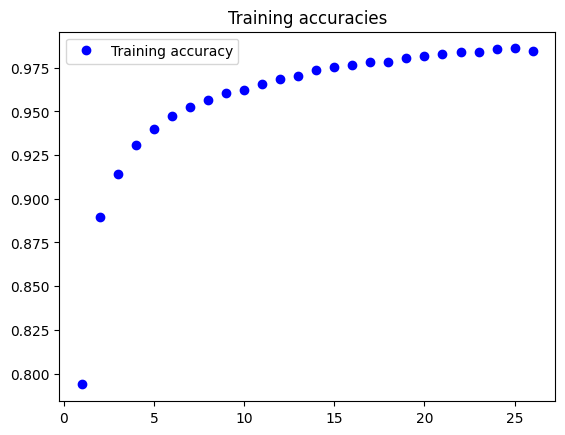

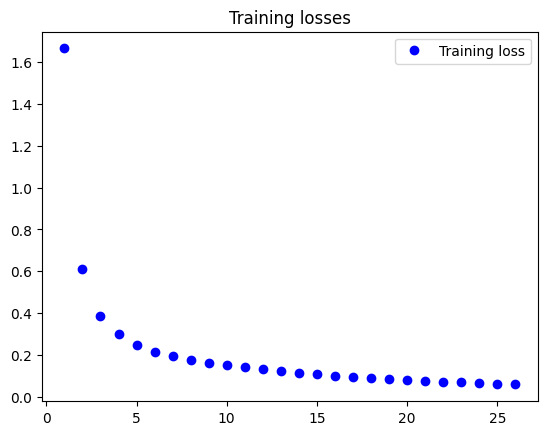

In [65]:
acc = history['accuracy']
loss = history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.title('Training accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training losses')
plt.legend()

plt.show()

We try the model on a test sentence

In [66]:
sentence = 'The United States might collapsez .'.lower().split()

Convert the sentence words to indices

In [67]:
# Write your code
# The indexes or the unknown word idx
sentence_word_idxs = [word2idx.get(word, 1) for word in sentence]

The indices. Note the 1 at the end.

In [68]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['the', 'united', 'states', 'might', 'collapsez', '.']
Sentence word indexes [1731494, 1796870, 1669408, 1256227, 1, 18920]


Predict the chunks. Call the variable `sent_chunk_predictions`

In [69]:
# Write your code
sent_chunk_predictions = model1(torch.LongTensor(sentence_word_idxs).to(device))

In [70]:
sent_chunk_predictions.shape

torch.Size([6, 23])

The estimated probabilities of the first chunk

In [71]:
F.softmax(sent_chunk_predictions[0], dim=-1)

tensor([8.5010e-08, 9.1991e-06, 1.3806e-04, 4.0274e-07, 3.1721e-05, 7.5362e-06,
        9.9927e-01, 5.8261e-07, 1.7679e-08, 9.6882e-06, 2.7822e-07, 7.6344e-07,
        4.1881e-08, 4.6079e-07, 1.8408e-06, 4.2224e-06, 5.5055e-05, 8.1020e-08,
        1.1245e-07, 8.8158e-07, 6.4205e-06, 2.1828e-06, 4.5968e-04],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [72]:
torch.argmax(F.softmax(sent_chunk_predictions, dim=-1), dim=-1)

tensor([ 6, 16, 16, 11, 21, 22], device='cuda:0')

We apply argmax to select the chunk

In [73]:
for word_nbr, chunk_predictions in enumerate(sent_chunk_predictions):
    if int(sentence_word_idxs[word_nbr]) in idx2word:
        print(idx2word[int(sentence_word_idxs[word_nbr])], end=': ')
    else:
        print(sentence[word_nbr], '/ukn', end=': ')
    print(idx2chunk.get(int(torch.argmax(F.softmax(chunk_predictions, dim=-1), dim=-1))))

the: B-NP
united: I-NP
states: I-NP
might: B-VP
collapsez /ukn: I-VP
.: O


## Evaluating the Model

In [74]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'calls', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP'},
  {'form': 'supply', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': '200', 'pos': 'CD', 'chunk': 'B-NP'},
  {'form': 'additional', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'so-called', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'shipsets', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'planes', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': '.', 'pos': '.', 'chunk': 'O'}]]

We create the ${X}$ and ${Y}$ sequences of symbols

In [75]:
X_test_symbs, Y_test_symbs = build_sequences(test_dict, key_x='form', key_y='chunk')
print('X_test:', X_test_symbs[1])
print('Y_test', Y_test_symbs[1])

X_test: ['rockwell', 'said', 'the', 'agreement', 'calls', 'for', 'it', 'to', 'supply', '200', 'additional', 'so-called', 'shipsets', 'for', 'the', 'planes', '.']
Y_test ['B-NP', 'B-VP', 'B-NP', 'I-NP', 'B-VP', 'B-SBAR', 'B-NP', 'B-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'O']


Convert the ${X}$ symbol sequence into an index sequence and pad it. Call the results `X_test_idx` and `X_test_padded`.

In [76]:
# Write your code
X_test_idx = []
for x in X_test_symbs:
    X_test_idx.append([word2idx.get(word, 1) for word in x])

In [77]:
X_test_idx = map(torch.LongTensor, X_test_idx)

In [78]:
X_test_padded = pad_sequence(X_test_idx, batch_first=True)

In [79]:
print('X_test_padded:', X_test_padded[1])

X_test_padded: tensor([1544992, 1565068, 1731494,  469497,  632240,  900752, 1075419, 1751214,
        1695414,  225306,  459199, 1642097, 1613783,  900752, 1731494, 1434430,
          18920,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0])


In [80]:
X_test_padded.shape

torch.Size([2012, 70])

In [81]:
# torch.save(model1.state_dict(), 'model.pt')
# torch.cuda.empty_cache()
# model1.load_state_dict(torch.load('model.pt'))
# model1.to('cpu')

Predict the chunks. Call the result `Y_test_hat_probs`

In [82]:
# Write your code
Y_test_hat_probs = model1(X_test_padded.to(device))

In [83]:
print('Predictions', Y_test_hat_probs[1])

Predictions tensor([[-5.5129,  0.4265, -0.5284,  ..., -2.0908, -5.9108,  1.9737],
        [-6.9847, -4.4360, -1.6372,  ..., -4.6631,  1.3284,  2.0589],
        [-8.8295, -1.8219, -1.2824,  ..., -3.6861, -4.2177,  1.2335],
        ...,
        [-6.2952, -2.3478, -1.7486,  ..., -1.9785, -4.9048,  3.9807],
        [-5.7952, -1.8021, -1.3064,  ..., -1.8298, -4.3204,  3.1336],
        [-5.0518, -1.5886, -1.2721,  ..., -1.5438, -4.1281,  2.3654]],
       device='cuda:0', grad_fn=<SelectBackward0>)


We now predict the whole test set and we store the results in each dictionary with the key `pchunk`

In [84]:
for sent, y_hat_probs in zip(test_dict, Y_test_hat_probs):
    sent_len = len(sent)
    y_hat_probs = y_hat_probs[:sent_len]
    # y_hat = torch.argmax(y_hat_probs, dim=-1) # This statement sometimes predicts 0 (the padding symbol)
    y_hat = torch.argmax(y_hat_probs[:, 1:], dim=-1) + 1 # Never predicts 0
    for word, ner_hat in zip(sent, y_hat):
        word['pchunk'] = idx2chunk.get(int(ner_hat)) 
        if word['pchunk'] == None:
            print(sent)

A sentence example: `chunk` is the hand annotation and `pchunk` is the prediction.

In [85]:
test_dict[1]

[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'calls', 'pos': 'VBZ', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-SBAR', 'pchunk': 'B-SBAR'},
 {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
 {'form': 'supply', 'pos': 'VB', 'chunk': 'I-VP', 'pchunk': 'I-VP'},
 {'form': '200', 'pos': 'CD', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
 {'form': 'additional', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'so-called', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'shipsets', 'pos': 'NNS', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP', 'pchunk': 'B-PP'},
 {'form': 'the', 'pos': 'DT', 'chu

We save the test set in a file to evaluate the performance of our model.

In [86]:
column_names = ['form', 'pos', 'chunk', 'pchunk']

In [87]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [88]:
outfile = 'test_model1.out'

In [89]:
save(outfile, test_dict, column_names)

In [90]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.9025198938992043

In [91]:
# Results may slightly vary depending on the run
# 0.8650974227443842 lstm nontrainable 15 epochs
# 0.8579701751845953 lstm trainable 15 epochs
# 0.9015216169521867 lstm bidi nontrainable 15 epochs
# 0.9000310655483068 lstm bidi trainable 15 epochs

## Experiments

You will carry out experiments with two different recurrent networks: RNN and LSTM. You will also try at least one set of parameters per network, i.e. two experiments, one with a RNN and one with a LSTM. To run a RNN, just replace the LSTM class with RNN. As baseline, a simple solution you consider a starting point, please report the baseline figures from CoNLL 2000: https://aclanthology.org/W00-0726.pdf. 

In your report, you will present your results in a table like this one:

|Method|Parameters|Score|
|------|-----|-----|
|Baseline|  xx | xx |
|RNN|  xx |xx |
|RNN |  xx |xx |
|LSTM |  xx |xx |
|LSTM |  xx |xx |
|  Akbik et al.|  xx|xx |

## Turning in your assignment

Now your are done with the program. To complete this assignment, you will:
1. Write a short individual report on your program. You will describe the architecture your used the different experiments you carried out and your results.
2. Read the article, <a href="https://www.aclweb.org/anthology/C18-1139"><i>Contextual String Embeddings for Sequence Labeling</i></a> by Akbik et al. (2018) and outline the main differences between their system and yours. A LSTM is a type of recurrent neural network, while CRF is a sort of beam search. You will tell the performance they reach on the corpus you used in this laboratory.

Submit your report as well as your notebook (for archiving purposes) to Canvas: https://canvas.education.lu.se/. To write your report, you can either
1. Write directly your text in Canvas, or
2. Use Latex and Overleaf (www.overleaf.com). This will probably help you structure your text. You will then upload a PDF file in Canvas.

The submission deadline is October 13, 2023.